# ToDo: 
+ ~~期待値がほぼ 0 になっている理由を探す。回避できるようなら回避~~
+ ~~C = 3 * n_qubits の理由~~ (特に理由はない？)
+ ~~QPU のばらつき改善~~
+ 2 次のトロッターにしてみる

## わかったこと
+ ハミルトニアンをシフトさせなければ成功
+ times = [2 * np.pi * k / C for k in range(n_features)] は失敗
+ times = [np.pi * k / C for k in range(n_features)] は成功

In [1]:
%matplotlib inline
%pip freeze > requirements.txt
%load_ext autoreload
%autoreload 2

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import pandas as pd
import os
from heisenberg_graph import (
    HeisenbergModel,
    get_n_steps,
    get_graph,
    get_positions,
    get_initial_layout,
    get_prob0,
    extract_probs,
)
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler, Batch
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
import mthree
import pickle
import networkx as nx
from datetime import datetime, timezone
import json
import math

In [3]:
# Option1: Use IBM Quantum backend.
# If you did not previously save your credentials, use the following line instead:
# service = QiskitRuntimeService(channel="ibm_quantum", token="<MY_IBM_QUANTUM_TOKEN>")
service = QiskitRuntimeService()
# backend_qpu = service.least_busy(simulator=False, interactional=True)
backend_qpu = service.backend("ibm_marrakesh")

# Option2: Use local AerSimulator as the backend.
backend_sim = AerSimulator()

noise_model = NoiseModel.from_backend(backend_qpu)
backend_sim_noisy = AerSimulator(noise_model=noise_model)

print(f"Using backend QPU: {backend_qpu}")
print(f"Using backend simulator: {backend_sim}")
print(f"Using backend noisy simulator: {backend_sim_noisy}")

Using backend QPU: <IBMBackend('ibm_marrakesh')>
Using backend simulator: AerSimulator('aer_simulator')
Using backend noisy simulator: AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['measure', 'reset', 'sx', 'cz', 'id', 'x']>)


# データセット作成 $\exp(-\beta H)$

In [4]:
n_samples = 100
n_qubits = 4
beta = 1

graph_type = "line"
# ghz_qubits = list(range(n_qubits // 2))
# ghz_qubits = list(range(0, n_qubits, 2))
# print(f"GHZ qubits: {ghz_qubits}")

## Create graph (Demo)

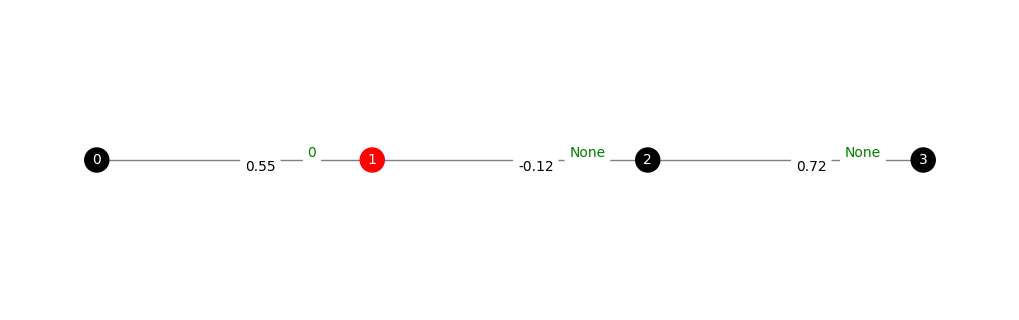

In [6]:
rng = np.random.default_rng(42)
G = get_graph(n_qubits, rng, graph_type)

positions = get_positions(n_qubits, graph_type)

# エッジラベルを作成
edge_J_labels = {edge: f"{G.edges[edge]['J']:.2g}" for edge in G.edges}
# edge_interaction_order_labels = {
#     edge: f"{G.edges[edge]['interaction_order']}" for edge in G.edges
# }
edge_cnot_order_labels = {edge: f"{G.edges[edge]['cnot']['order']}" for edge in G.edges}

# グラフを描画
plt.figure(figsize=(10, 3))
nx.draw(
    G,
    pos=positions,
    with_labels=True,
    node_color=["red" if G.nodes[node]["hadamard"] else "black" for node in G.nodes],
    node_size=300,
    edge_color="gray",
    font_color="white",
    font_size=10,
)

# エッジの重みを描画
nx.draw_networkx_edge_labels(
    G,
    pos=positions,
    edge_labels=edge_J_labels,
    font_size=10,
    font_color="black",
    label_pos=0.6,
    verticalalignment="top",
)

# エッジの 'interaction_order' 属性を描画
# nx.draw_networkx_edge_labels(
#     G,
#     pos=positions,
#     edge_labels=edge_interaction_order_labels,
#     font_size=10,
#     font_color="blue",
#     label_pos=0.4,
#     verticalalignment="bottom",
# )

# エッジの 'cnot' 'order' 属性を描画
nx.draw_networkx_edge_labels(
    G,
    pos=positions,
    edge_labels=edge_cnot_order_labels,
    font_size=10,
    font_color="green",
    label_pos=0.8,
    verticalalignment="bottom",
)

plt.show()

In [7]:
# State |111000> (half 1 and half 0 state) (can be adjusted for other sizes)
state = np.zeros(2**n_qubits, dtype=complex)
index = int("1" * (n_qubits // 2) + "0" * (n_qubits // 2), 2)
state[index] = 1
print("1" * (n_qubits // 2) + "0" * (n_qubits // 2))
print(f"index: {index}")

1100
index: 12


## Non Trotter simulation (directly compute the expectation value)

In [8]:
# rng = np.random.default_rng(42)
# G = get_graph(n_qubits, rng, graph_type)
# print(f"Js: {G.edges(data='J')}")
# heisenberg = HeisenbergModel(n_qubits, G)
# print(f"pauli_strings: {heisenberg.get_pauli_strings()}")
# print()

# H, eigvals = heisenberg.get_hamiltonian_and_eigvals()
# print(f"Hamiltonian: \n{H}")

In [9]:
data = []
eigvals_list = []
graphs = []
matrix_norms = []  # For debugging
rng = np.random.default_rng(42)

for i in range(n_samples):
    print(f"Sample {i}/{n_samples}")
    G = get_graph(n_qubits, rng, graph_type)
    Js = [G.edges[edge]["J"] for edge in G.edges]
    heisenberg = HeisenbergModel(n_qubits, G)

    H = heisenberg.H
    eigvals = heisenberg.eigvals
    eigvals_list.append(eigvals)
    matrix_norms.append(np.linalg.norm(H, ord=2))

    # fH = (scipy.linalg.expm(beta * H) + scipy.linalg.expm(-beta * H)) / 2
    fH = scipy.linalg.expm(-beta * H)

    # Compute the expectation value <111000|exp(-beta*H)|111000>
    y = np.vdot(state, fH @ state).real
    data.append({"Js": Js, "expected_value": y})
    graphs.append(G)

df = pd.DataFrame(data)
df

Sample 0/100
Sample 1/100
Sample 2/100
Sample 3/100
Sample 4/100
Sample 5/100
Sample 6/100
Sample 7/100
Sample 8/100
Sample 9/100
Sample 10/100
Sample 11/100
Sample 12/100
Sample 13/100
Sample 14/100
Sample 15/100
Sample 16/100
Sample 17/100
Sample 18/100
Sample 19/100
Sample 20/100
Sample 21/100
Sample 22/100
Sample 23/100
Sample 24/100
Sample 25/100
Sample 26/100
Sample 27/100
Sample 28/100
Sample 29/100
Sample 30/100
Sample 31/100
Sample 32/100
Sample 33/100
Sample 34/100
Sample 35/100
Sample 36/100
Sample 37/100
Sample 38/100
Sample 39/100
Sample 40/100
Sample 41/100
Sample 42/100
Sample 43/100
Sample 44/100
Sample 45/100
Sample 46/100
Sample 47/100
Sample 48/100
Sample 49/100
Sample 50/100
Sample 51/100
Sample 52/100
Sample 53/100
Sample 54/100
Sample 55/100
Sample 56/100
Sample 57/100
Sample 58/100
Sample 59/100
Sample 60/100
Sample 61/100
Sample 62/100
Sample 63/100
Sample 64/100
Sample 65/100
Sample 66/100
Sample 67/100
Sample 68/100
Sample 69/100
Sample 70/100
Sample 71/100
Sa

,Js,expected_value
0,"[0.5479120971119267, -0.12224312049589536, 0.7...",0.285440
1,"[0.3947360581187278, -0.8116453042247009, 0.95...",1.439068
2,"[0.5222794039807059, 0.5721286105539076, -0.74...",3.932849
3,"[-0.09922812420886573, -0.25840395153483753, 0...",0.491069
4,"[0.2877302401613291, 0.64552322654166, -0.1131...",3.379307
...,...,...
95,"[-0.16747514859361545, -0.901491760144812, -0....",1.645128
96,"[0.04750589743527445, -0.7966561941925681, 0.6...",1.006801
97,"[-0.8960762670697915, 0.8496837380361242, -0.8...",23.844404
98,"[0.6871499031955055, 0.8053062878552342, 0.959...",6.247454


## Pre-process data

In [10]:
df["expected_value"].describe()

count    100.000000
mean       3.292790
std        3.814038
min        0.285440
25%        1.033086
50%        1.748295
75%        4.297242
max       23.844404
Name: expected_value, dtype: float64

In [11]:
q = df["expected_value"].quantile(0.95)
print(f"95% quantile: {q}")

df = df.query("expected_value < @q")
df["expected_value"].describe()

95% quantile: 11.224789475546611


count    95.000000
mean      2.629654
std       2.347752
min       0.285440
25%       1.023569
50%       1.678229
75%       3.418302
max      11.151831
Name: expected_value, dtype: float64

In [12]:
display(df)

n_samples = len(df)

,Js,expected_value
0,"[0.5479120971119267, -0.12224312049589536, 0.7...",0.285440
1,"[0.3947360581187278, -0.8116453042247009, 0.95...",1.439068
2,"[0.5222794039807059, 0.5721286105539076, -0.74...",3.932849
3,"[-0.09922812420886573, -0.25840395153483753, 0...",0.491069
4,"[0.2877302401613291, 0.64552322654166, -0.1131...",3.379307
...,...,...
94,"[-0.526510257791208, -0.5012248483355763, 0.14...",1.308481
95,"[-0.16747514859361545, -0.901491760144812, -0....",1.645128
96,"[0.04750589743527445, -0.7966561941925681, 0.6...",1.006801
98,"[0.6871499031955055, 0.8053062878552342, 0.959...",6.247454


## Check eigvals and Configure params

Number of samples: 95


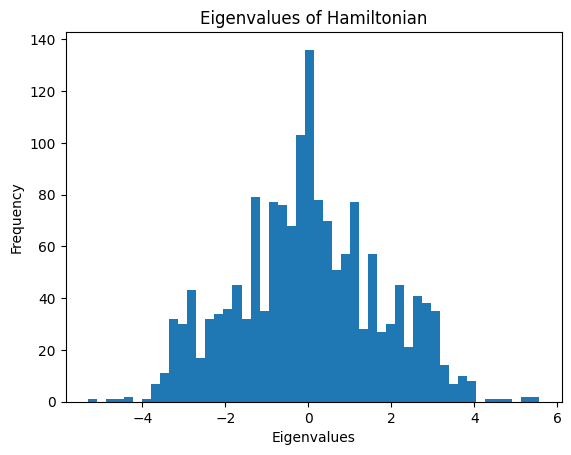

In [13]:
# Plot histogram of eigenvalues
print(f"Number of samples: {n_samples}")
eigvals_array = np.array(eigvals_list).flatten()
plt.hist(eigvals_array, bins=50)
plt.xlabel("Eigenvalues")
plt.ylabel("Frequency")
plt.title("Eigenvalues of Hamiltonian")
plt.show()

In [14]:
n_features = 5  # Number of Fourier features

# Parameters for the Fourier feature generation
# For shifted Hamiltonian
# C = 20 * n_qubits  # upper bound for eigenvalues (WHY?)
# times = [2 * np.pi * k / C for k in range(n_features)]

# For unshifted Hamiltonian
C = 10 * n_qubits  # upper bound for eigenvalues
times = [np.pi * k / C for k in range(n_features)]

# C = max(matrix_norms)  # upper bound for eigenvalues
print(f"C: {C}")
print(f"max matrix norm: {max(matrix_norms)}")  # For debugging
print(f"times: {times}")

C: 40
max matrix norm: 5.557695250469752
times: [0.0, 0.07853981633974483, 0.15707963267948966, 0.23561944901923448, 0.3141592653589793]


In [15]:
current_time = (
    datetime.now(timezone.utc).isoformat(timespec="minutes").replace("+00:00", "Z")
)

path = f"./data/{current_time}_{n_qubits}_{backend_qpu.name}_{graph_type}"
os.makedirs(path, exist_ok=True)
print(f"current_time: {current_time}")
print(f"Saving data to {path}")

current_time: 2024-11-26T16:17Z
Saving data to ./data/2024-11-26T16:17Z_4_ibm_marrakesh_line


In [16]:
# Save parameters
with open(
    f"./data/{current_time}_{n_qubits}_{backend_qpu.name}_{graph_type}/params.pkl", "wb"
) as f:
    pickle.dump(
        {
            "n_samples": n_samples,
            "n_qubits": n_qubits,
            "backend_qpu_name": backend_qpu.name,
            "beta": beta,
            "C": C,
            "n_features": n_features,
            "times": times,
            "Js": df["Js"].values,
            "graphs": graphs,
            "expected_values": df["expected_value"].values,
        },
        f,
    )

In [17]:
# Load parameters
with open(f"{path}/params.pkl", "rb") as f:
    params = pickle.load(f)

n_samples = params["n_samples"]
n_qubits = params["n_qubits"]
backend_qpu_name = params["backend_qpu_name"]
beta = params["beta"]
C = params["C"]
n_features = params["n_features"]
times = params["times"]
all_Js = params["Js"]
graphs = params["graphs"]
all_expected_values = params["expected_values"]

# Create Fourier feature

## Trotter simulation (Exact)

In [18]:
# Exact simulation
data = []
probs_phase0_exact = {}
probs_phase1_exact = {}
probs_phase2_exact = {}
probs_phase3_exact = {}

# Generate the dataset with Fourier features
for i in range(n_samples):
    print(f"Calculating features for sample {i}/{n_samples}")
    Js = all_Js[i]
    lambda_ref = np.sum(Js)  # Reference eigenvalue.
    heisenberg_exact = HeisenbergModel(n_qubits, graphs[i])
    features_exact = []

    probs_phase0_exact[f"sample{i}"] = {}
    probs_phase1_exact[f"sample{i}"] = {}
    probs_phase2_exact[f"sample{i}"] = {}
    probs_phase3_exact[f"sample{i}"] = {}

    # Compute the Fourier features for different times
    for k in range(n_features):
        prob_phase0 = heisenberg_exact.exact_simulation(times[k], phase=0)
        prob_phase1 = heisenberg_exact.exact_simulation(times[k], phase=1)
        prob_phase2 = heisenberg_exact.exact_simulation(times[k], phase=2)
        prob_phase3 = heisenberg_exact.exact_simulation(times[k], phase=3)

        probs_phase0_exact[f"sample{i}"][f"f_{k}"] = prob_phase0
        probs_phase1_exact[f"sample{i}"][f"f_{k}"] = prob_phase1
        probs_phase2_exact[f"sample{i}"][f"f_{k}"] = prob_phase2
        probs_phase3_exact[f"sample{i}"][f"f_{k}"] = prob_phase3

        inner_product = np.exp(-1j * lambda_ref * times[k]) * (
            (prob_phase0 - prob_phase1) + 1j * (prob_phase2 - prob_phase3)
        )

        # For shifted Hamiltonian
        # inner_product = (
        #     np.exp(-1j * heisenberg_exact.min_eigval_before * times[k]) * inner_product
        # )

        features_exact.append(inner_product.real)
        if k != 0:
            features_exact.append(inner_product.imag)
    data.append([i, *features_exact, all_expected_values[i]])

# Create column names for the DataFrame
columns = []
columns.append("sample_id")
for k in range(n_features):
    columns.append(f"f_{k} Re")
    if k != 0:
        columns.append(f"f_{k} Im")
columns.append("expected_value")

# Convert to a DataFrame
data_exact_df = pd.DataFrame(data, columns=columns)
display(data_exact_df)

# Save the exact data
data_exact_df.to_json(f"{path}/data_exact_df.json")

Calculating features for sample 0/95
Calculating features for sample 1/95
Calculating features for sample 2/95
Calculating features for sample 3/95
Calculating features for sample 4/95
Calculating features for sample 5/95
Calculating features for sample 6/95
Calculating features for sample 7/95
Calculating features for sample 8/95
Calculating features for sample 9/95
Calculating features for sample 10/95
Calculating features for sample 11/95
Calculating features for sample 12/95
Calculating features for sample 13/95
Calculating features for sample 14/95
Calculating features for sample 15/95
Calculating features for sample 16/95
Calculating features for sample 17/95
Calculating features for sample 18/95
Calculating features for sample 19/95
Calculating features for sample 20/95
Calculating features for sample 21/95
Calculating features for sample 22/95
Calculating features for sample 23/95
Calculating features for sample 24/95
Calculating features for sample 25/95
Calculating features f

,sample_id,f_0 Re,f_1 Re,f_1 Im,f_2 Re,f_2 Im,f_3 Re,f_3 Im,f_4 Re,f_4 Im,expected_value
0,0,1.0,0.993886,-0.108739,0.975622,-0.216141,0.945442,-0.320885,0.903734,-0.421682,0.285440
1,1,1.0,0.977627,-0.167849,0.911851,-0.326142,0.806613,-0.465869,0.668207,-0.579078,1.439068
2,2,1.0,0.994035,0.062086,0.976324,0.122713,0.947416,0.180467,0.908200,0.234027,3.932849
3,3,1.0,0.996017,-0.079421,0.984116,-0.158142,0.964441,-0.235471,0.937228,-0.310724,0.491069
4,4,1.0,0.994186,0.036744,0.976877,0.072025,0.948466,0.104419,0.909597,0.132580,3.379307
...,...,...,...,...,...,...,...,...,...,...,...
90,90,1.0,0.994316,-0.032028,0.978123,-0.060278,0.953804,-0.081748,0.924726,-0.094795,1.308481
91,91,1.0,0.985544,0.159638,0.942756,0.313660,0.873352,0.456694,0.780103,0.583849,1.645128
92,92,1.0,0.999968,0.007880,0.999872,0.015760,0.999712,0.023639,0.999488,0.031515,1.006801
93,93,1.0,0.934405,-0.326338,0.750715,-0.597460,0.485135,-0.770314,0.188498,-0.823208,6.247454


## Trotter simulation (Simulator, Noise free)

In [19]:
# Create circuits
# 1 jobs - 1 sample
circuits_phase0 = {}
circuits_phase1 = {}
circuits_phase2 = {}
circuits_phase3 = {}
exec_circuits_phase0 = {}
exec_circuits_phase1 = {}
exec_circuits_phase2 = {}
exec_circuits_phase3 = {}
lambda_refs = {}

for i in range(n_samples):
    print(f"Creating circuits for sample {i}/{n_samples}")
    Js = all_Js[i]
    # lambda_refs.append(np.sum(Js))  # Reference eigenvalue.
    lambda_refs[f"sample{i}"] = np.sum(Js)  # Reference eigenvalue.
    heisenberg_sim = HeisenbergModel(n_qubits, graphs[i], backend=backend_sim)

    circuits_phase0[f"sample{i}"] = {}
    circuits_phase1[f"sample{i}"] = {}
    circuits_phase2[f"sample{i}"] = {}
    circuits_phase3[f"sample{i}"] = {}
    exec_circuits_phase0[f"sample{i}"] = {}
    exec_circuits_phase1[f"sample{i}"] = {}
    exec_circuits_phase2[f"sample{i}"] = {}
    exec_circuits_phase3[f"sample{i}"] = {}
    for k in range(n_features):
        n_steps = get_n_steps(times[k])
        circuit_phase0, exec_circuit_phase0 = (
            heisenberg_sim.get_trotter_simulation_circuit(times[k], n_steps, phase=0)
        )
        circuit_phase1, exec_circuit_phase1 = (
            heisenberg_sim.get_trotter_simulation_circuit(times[k], n_steps, phase=1)
        )
        circuit_phase2, exec_circuit_phase2 = (
            heisenberg_sim.get_trotter_simulation_circuit(times[k], n_steps, phase=2)
        )
        circuit_phase3, exec_circuit_phase3 = (
            heisenberg_sim.get_trotter_simulation_circuit(times[k], n_steps, phase=3)
        )

        circuits_phase0[f"sample{i}"][f"f_{k}"] = circuit_phase0
        circuits_phase1[f"sample{i}"][f"f_{k}"] = circuit_phase1
        circuits_phase2[f"sample{i}"][f"f_{k}"] = circuit_phase2
        circuits_phase3[f"sample{i}"][f"f_{k}"] = circuit_phase3
        exec_circuits_phase0[f"sample{i}"][f"f_{k}"] = exec_circuit_phase0
        exec_circuits_phase1[f"sample{i}"][f"f_{k}"] = exec_circuit_phase1
        exec_circuits_phase2[f"sample{i}"][f"f_{k}"] = exec_circuit_phase2
        exec_circuits_phase3[f"sample{i}"][f"f_{k}"] = exec_circuit_phase3

Creating circuits for sample 0/95
Creating circuits for sample 1/95
Creating circuits for sample 2/95
Creating circuits for sample 3/95
Creating circuits for sample 4/95
Creating circuits for sample 5/95
Creating circuits for sample 6/95
Creating circuits for sample 7/95
Creating circuits for sample 8/95
Creating circuits for sample 9/95
Creating circuits for sample 10/95
Creating circuits for sample 11/95
Creating circuits for sample 12/95
Creating circuits for sample 13/95
Creating circuits for sample 14/95
Creating circuits for sample 15/95
Creating circuits for sample 16/95
Creating circuits for sample 17/95
Creating circuits for sample 18/95
Creating circuits for sample 19/95
Creating circuits for sample 20/95
Creating circuits for sample 21/95
Creating circuits for sample 22/95
Creating circuits for sample 23/95
Creating circuits for sample 24/95
Creating circuits for sample 25/95
Creating circuits for sample 26/95
Creating circuits for sample 27/95
Creating circuits for sample 2

In [20]:
# Run jobs in batch
jobs = []  # For AerSimulator, we can't use job ids.
with Batch(backend=backend_sim):
    sampler = Sampler()

    for i in range(n_samples):
        print(f"Running circuits for sample {i}/{n_samples}")
        exec_circuits_per_sample = []
        exec_circuits_per_sample += [
            exec_circuits_phase0[f"sample{i}"][f"f_{k}"] for k in range(n_features)
        ]
        exec_circuits_per_sample += [
            exec_circuits_phase1[f"sample{i}"][f"f_{k}"] for k in range(n_features)
        ]
        exec_circuits_per_sample += [
            exec_circuits_phase2[f"sample{i}"][f"f_{k}"] for k in range(n_features)
        ]
        exec_circuits_per_sample += [
            exec_circuits_phase3[f"sample{i}"][f"f_{k}"] for k in range(n_features)
        ]

        job = sampler.run(exec_circuits_per_sample)
        jobs.append(job)

Running circuits for sample 0/95
Running circuits for sample 1/95
Running circuits for sample 2/95
Running circuits for sample 3/95
Running circuits for sample 4/95
Running circuits for sample 5/95
Running circuits for sample 6/95
Running circuits for sample 7/95
Running circuits for sample 8/95
Running circuits for sample 9/95
Running circuits for sample 10/95
Running circuits for sample 11/95
Running circuits for sample 12/95
Running circuits for sample 13/95
Running circuits for sample 14/95
Running circuits for sample 15/95
Running circuits for sample 16/95
Running circuits for sample 17/95
Running circuits for sample 18/95
Running circuits for sample 19/95
Running circuits for sample 20/95
Running circuits for sample 21/95
Running circuits for sample 22/95
Running circuits for sample 23/95
Running circuits for sample 24/95
Running circuits for sample 25/95
Running circuits for sample 26/95
Running circuits for sample 27/95
Running circuits for sample 28/95
Running circuits for sam

In [21]:
check_list = []
for i in range(n_samples):
    job_id = jobs[i].job_id()
    check_list.append(
        {
            "Job ID": job_id,
            "sample_id": i,
            "Status": job.status().name,
        }
    )

check_df = pd.DataFrame(check_list)
display(check_df)

,Job ID,sample_id,Status
0,d861f417-1c92-4006-b802-54f99b7e6304,0,DONE
1,a052d44e-af9d-4403-b4b7-40e7dd430a05,1,DONE
2,2a0817ba-e604-43c7-954e-a6423befd026,2,DONE
3,d055617c-a7ca-46a7-8e1b-a8b7495540ac,3,DONE
4,57e1a48b-d748-41f3-a83f-90f8ba6a3695,4,DONE
...,...,...,...
90,0f45818d-7775-4929-b61b-5c258326d58e,90,DONE
91,563f3268-d70b-4af3-9ffe-cf71ff040ca2,91,DONE
92,aa214101-197d-4295-8491-2370452eec4a,92,DONE
93,a0a87105-2275-40a5-87b5-aa3a9aaa6f5b,93,DONE


In [22]:
# Post-process
data_sim = []
probs_phase0_sim = {}
probs_phase1_sim = {}
probs_phase2_sim = {}
probs_phase3_sim = {}

for i in range(n_samples):
    features = []
    probs_phase0_sim[f"sample{i}"] = {}
    probs_phase1_sim[f"sample{i}"] = {}
    probs_phase2_sim[f"sample{i}"] = {}
    probs_phase3_sim[f"sample{i}"] = {}

    # Compute the Fourier features for different times
    for k in range(n_features):
        # Get results of each phase in a batch
        results_phase0 = jobs[i].result()[:n_features]
        results_phase1 = jobs[i].result()[n_features : 2 * n_features]
        results_phase2 = jobs[i].result()[2 * n_features : 3 * n_features]
        results_phase3 = jobs[i].result()[3 * n_features :]

        prob_phase0 = get_prob0(results_phase0[k], n_qubits)
        prob_phase1 = get_prob0(results_phase1[k], n_qubits)
        prob_phase2 = get_prob0(results_phase2[k], n_qubits)
        prob_phase3 = get_prob0(results_phase3[k], n_qubits)

        probs_phase0_sim[f"sample{i}"][f"f_{k}"] = prob_phase0
        probs_phase1_sim[f"sample{i}"][f"f_{k}"] = prob_phase1
        probs_phase2_sim[f"sample{i}"][f"f_{k}"] = prob_phase2
        probs_phase3_sim[f"sample{i}"][f"f_{k}"] = prob_phase3

        inner_product = np.exp(-1j * lambda_refs[f"sample{i}"] * times[k]) * (
            (prob_phase0 - prob_phase1) + 1j * (prob_phase2 - prob_phase3)
        )

        features.append(inner_product.real)
        if k != 0:
            features.append(inner_product.imag)
    data_sim.append([i, *features, all_expected_values[i]])

# Create column names for the DataFrame
columns = []
columns.append("sample_id")
for k in range(n_features):
    columns.append(f"f_{k} Re")
    if k != 0:
        columns.append(f"f_{k} Im")
columns.append("expected_value")

# Convert to a DataFrame
data_sim_df = pd.DataFrame(data_sim, columns=columns)
display(data_sim_df)

# Save the simulation data
data_sim_df.to_json(f"{path}/data_sim_df.json")

 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No co

,sample_id,f_0 Re,f_1 Re,f_1 Im,f_2 Re,f_2 Im,f_3 Re,f_3 Im,f_4 Re,f_4 Im,expected_value
0,0,1.0,0.994486,-0.106175,0.976691,-0.212975,0.949447,-0.307621,0.904667,-0.427148,0.285440
1,1,1.0,0.976231,-0.168058,0.895297,-0.354626,0.801954,-0.492291,0.670049,-0.558275,1.439068
2,2,1.0,0.992959,0.049826,0.971283,0.090223,0.943992,0.157990,0.916226,0.235666,3.932849
3,3,1.0,0.996136,-0.093546,0.982767,-0.184457,0.957959,-0.249117,0.935324,-0.319899,0.491069
4,4,1.0,0.989783,0.006619,0.983696,0.083307,0.938538,0.117867,0.914973,0.126513,3.379307
...,...,...,...,...,...,...,...,...,...,...,...
90,90,1.0,1.000645,-0.086942,0.992215,-0.079052,0.946591,-0.072148,0.956406,-0.112855,1.308481
91,91,1.0,0.985105,0.147797,0.948686,0.314614,0.863468,0.475953,0.777946,0.588443,1.645128
92,92,1.0,1.000067,-0.007213,0.999727,0.027564,0.999812,0.019375,1.000474,-0.005408,1.006801
93,93,1.0,0.932823,-0.339068,0.744183,-0.605118,0.479862,-0.800038,0.194628,-0.809202,6.247454


## Trotter simulation (Simulator, Noisy)

In [23]:
# Create circuits
# 1 jobs - 1 sample
circuits_phase0 = {}
circuits_phase1 = {}
circuits_phase2 = {}
circuits_phase3 = {}
exec_circuits_phase0 = {}
exec_circuits_phase1 = {}
exec_circuits_phase2 = {}
exec_circuits_phase3 = {}

for i in range(n_samples):
    print(f"Creating circuits for sample {i}/{n_samples}")
    Js = all_Js[i]
    heisenberg_sim_noisy = HeisenbergModel(
        n_qubits, graphs[i], backend=backend_sim_noisy
    )

    circuits_phase0[f"sample{i}"] = {}
    circuits_phase1[f"sample{i}"] = {}
    circuits_phase2[f"sample{i}"] = {}
    circuits_phase3[f"sample{i}"] = {}
    exec_circuits_phase0[f"sample{i}"] = {}
    exec_circuits_phase1[f"sample{i}"] = {}
    exec_circuits_phase2[f"sample{i}"] = {}
    exec_circuits_phase3[f"sample{i}"] = {}
    for k in range(n_features):
        n_steps = get_n_steps(times[k])
        circuit_phase0, exec_circuit_phase0 = (
            heisenberg_sim_noisy.get_trotter_simulation_circuit(
                times[k], n_steps, phase=0
            )
        )
        circuit_phase1, exec_circuit_phase1 = (
            heisenberg_sim_noisy.get_trotter_simulation_circuit(
                times[k], n_steps, phase=1
            )
        )
        circuit_phase2, exec_circuit_phase2 = (
            heisenberg_sim_noisy.get_trotter_simulation_circuit(
                times[k], n_steps, phase=2
            )
        )
        circuit_phase3, exec_circuit_phase3 = (
            heisenberg_sim_noisy.get_trotter_simulation_circuit(
                times[k], n_steps, phase=3
            )
        )

        circuits_phase0[f"sample{i}"][f"f_{k}"] = circuit_phase0
        circuits_phase1[f"sample{i}"][f"f_{k}"] = circuit_phase1
        circuits_phase2[f"sample{i}"][f"f_{k}"] = circuit_phase2
        circuits_phase3[f"sample{i}"][f"f_{k}"] = circuit_phase3
        exec_circuits_phase0[f"sample{i}"][f"f_{k}"] = exec_circuit_phase0
        exec_circuits_phase1[f"sample{i}"][f"f_{k}"] = exec_circuit_phase1
        exec_circuits_phase2[f"sample{i}"][f"f_{k}"] = exec_circuit_phase2
        exec_circuits_phase3[f"sample{i}"][f"f_{k}"] = exec_circuit_phase3

Creating circuits for sample 0/95
Creating circuits for sample 1/95
Creating circuits for sample 2/95
Creating circuits for sample 3/95
Creating circuits for sample 4/95
Creating circuits for sample 5/95
Creating circuits for sample 6/95
Creating circuits for sample 7/95
Creating circuits for sample 8/95
Creating circuits for sample 9/95
Creating circuits for sample 10/95
Creating circuits for sample 11/95
Creating circuits for sample 12/95
Creating circuits for sample 13/95
Creating circuits for sample 14/95
Creating circuits for sample 15/95
Creating circuits for sample 16/95
Creating circuits for sample 17/95
Creating circuits for sample 18/95
Creating circuits for sample 19/95
Creating circuits for sample 20/95
Creating circuits for sample 21/95
Creating circuits for sample 22/95
Creating circuits for sample 23/95
Creating circuits for sample 24/95
Creating circuits for sample 25/95
Creating circuits for sample 26/95
Creating circuits for sample 27/95
Creating circuits for sample 2

In [24]:
# Run jobs in batch
jobs = []  # For AerSimulator, we can't use job ids.
with Batch(backend=backend_sim_noisy):
    sampler = Sampler()

    for i in range(n_samples):
        print(f"Running circuits for sample {i}/{n_samples}")
        exec_circuits_per_sample = []
        exec_circuits_per_sample += [
            exec_circuits_phase0[f"sample{i}"][f"f_{k}"] for k in range(n_features)
        ]
        exec_circuits_per_sample += [
            exec_circuits_phase1[f"sample{i}"][f"f_{k}"] for k in range(n_features)
        ]
        exec_circuits_per_sample += [
            exec_circuits_phase2[f"sample{i}"][f"f_{k}"] for k in range(n_features)
        ]
        exec_circuits_per_sample += [
            exec_circuits_phase3[f"sample{i}"][f"f_{k}"] for k in range(n_features)
        ]

        job = sampler.run(exec_circuits_per_sample)
        jobs.append(job)

Running circuits for sample 0/95
Running circuits for sample 1/95
Running circuits for sample 2/95
Running circuits for sample 3/95
Running circuits for sample 4/95
Running circuits for sample 5/95
Running circuits for sample 6/95
Running circuits for sample 7/95
Running circuits for sample 8/95
Running circuits for sample 9/95
Running circuits for sample 10/95
Running circuits for sample 11/95
Running circuits for sample 12/95
Running circuits for sample 13/95
Running circuits for sample 14/95
Running circuits for sample 15/95
Running circuits for sample 16/95
Running circuits for sample 17/95
Running circuits for sample 18/95
Running circuits for sample 19/95
Running circuits for sample 20/95
Running circuits for sample 21/95
Running circuits for sample 22/95
Running circuits for sample 23/95
Running circuits for sample 24/95
Running circuits for sample 25/95
Running circuits for sample 26/95
Running circuits for sample 27/95
Running circuits for sample 28/95
Running circuits for sam

In [25]:
check_list = []
for i in range(n_samples):
    job_id = jobs[i].job_id()
    check_list.append(
        {
            "Job ID": job_id,
            "sample_id": i,
            "Status": job.status().name,
        }
    )

check_df = pd.DataFrame(check_list)
display(check_df)

,Job ID,sample_id,Status
0,0b3ee2ab-f830-4e09-af96-9008abc608c4,0,DONE
1,4513f8d4-09ab-4963-a8cc-5330d780e703,1,DONE
2,7c95248f-07e6-4e29-9788-12fc4d1a4bf4,2,DONE
3,344e4c61-c23e-4a23-8521-eac737e54cb1,3,DONE
4,5fe08870-606e-4559-b556-93d154bf87e8,4,DONE
...,...,...,...
90,6b4aed59-6763-4129-a9fe-6f6c7e2690ee,90,DONE
91,6ab87277-3bef-4d29-ae8d-c171ca9121f3,91,DONE
92,4d24e456-7347-4d28-8550-72064806df2b,92,DONE
93,8b00e3f8-4f0c-4d85-b999-b3246e18b1c4,93,DONE


In [26]:
# Post-process
data_sim_noisy = []
probs_phase0_sim_noisy = {}
probs_phase1_sim_noisy = {}
probs_phase2_sim_noisy = {}
probs_phase3_sim_noisy = {}

for i in range(n_samples):
    features = []
    probs_phase0_sim_noisy[f"sample{i}"] = {}
    probs_phase1_sim_noisy[f"sample{i}"] = {}
    probs_phase2_sim_noisy[f"sample{i}"] = {}
    probs_phase3_sim_noisy[f"sample{i}"] = {}

    # Compute the Fourier features for different times
    for k in range(n_features):
        # Get results of each phase in a batch
        results_phase0 = jobs[i].result()[:n_features]
        results_phase1 = jobs[i].result()[n_features : 2 * n_features]
        results_phase2 = jobs[i].result()[2 * n_features : 3 * n_features]
        results_phase3 = jobs[i].result()[3 * n_features :]

        prob_phase0 = get_prob0(results_phase0[k], n_qubits)
        prob_phase1 = get_prob0(results_phase1[k], n_qubits)
        prob_phase2 = get_prob0(results_phase2[k], n_qubits)
        prob_phase3 = get_prob0(results_phase3[k], n_qubits)

        probs_phase0_sim_noisy[f"sample{i}"][f"f_{k}"] = prob_phase0
        probs_phase1_sim_noisy[f"sample{i}"][f"f_{k}"] = prob_phase1
        probs_phase2_sim_noisy[f"sample{i}"][f"f_{k}"] = prob_phase2
        probs_phase3_sim_noisy[f"sample{i}"][f"f_{k}"] = prob_phase3

        inner_product = np.exp(-1j * lambda_refs[f"sample{i}"] * times[k]) * (
            (prob_phase0 - prob_phase1) + 1j * (prob_phase2 - prob_phase3)
        )
        features.append(inner_product.real)
        if k != 0:
            features.append(inner_product.imag)
    data_sim_noisy.append([i, *features, all_expected_values[i]])

# Create column names for the DataFrame
columns = []
columns.append("sample_id")
for k in range(n_features):
    columns.append(f"f_{k} Re")
    if k != 0:
        columns.append(f"f_{k} Im")
columns.append("expected_value")

# Convert to a DataFrame
data_sim_noisy_df = pd.DataFrame(data_sim_noisy, columns=columns)
display(data_sim_noisy_df)

# Save the simulation data
data_sim_noisy_df.to_json(f"{path}/data_sim_noisy_df.json")

,sample_id,f_0 Re,f_1 Re,f_1 Im,f_2 Re,f_2 Im,f_3 Re,f_3 Im,f_4 Re,f_4 Im,expected_value
0,0,0.969727,0.914993,-0.096079,0.920953,-0.181025,0.854396,-0.329002,0.865599,-0.347815,0.285440
1,1,0.971680,0.890172,-0.145873,0.826088,-0.291962,0.735398,-0.450399,0.601899,-0.527907,1.439068
2,2,0.974609,0.922700,0.052738,0.907996,0.130878,0.874012,0.141247,0.830291,0.204888,3.932849
3,3,0.972656,0.927956,-0.062547,0.905055,-0.088274,0.905284,-0.186888,0.884683,-0.226931,0.491069
4,4,0.976562,0.909619,0.068548,0.892876,0.089163,0.884097,0.129515,0.838419,0.104269,3.379307
...,...,...,...,...,...,...,...,...,...,...,...
90,90,0.976562,0.909599,-0.030631,0.905561,-0.051737,0.876498,-0.089978,0.875386,-0.106535,1.308481
91,91,0.965820,0.913511,0.165866,0.870231,0.270143,0.793857,0.434053,0.726081,0.519685,1.645128
92,92,0.975586,0.922013,-0.018460,0.931765,-0.003590,0.919435,-0.016369,0.922551,-0.014260,1.006801
93,93,0.980469,0.858409,-0.317596,0.669822,-0.567601,0.432931,-0.714660,0.170824,-0.742575,6.247454


## Trotter simulation (QPU)

In [24]:
# For the case session is expired, you can reinitialize the service with the following line.
backend_qpu = service.backend(backend_qpu.name)

In [25]:
initial_layout = get_initial_layout(n_qubits, graph_type, backend_qpu.name)

In [26]:
# Create circuits
# 1 jobs - 1 sample
circuits_phase0 = {}
circuits_phase1 = {}
circuits_phase2 = {}
circuits_phase3 = {}
exec_circuits_phase0 = {}
exec_circuits_phase1 = {}
exec_circuits_phase2 = {}
exec_circuits_phase3 = {}

for i in range(n_samples):
    print(f"Creating circuits for sample {i}/{n_samples}")
    Js = all_Js[i]
    heisenberg_qpu = HeisenbergModel(n_qubits, graphs[i], backend=backend_qpu)

    circuits_phase0[f"sample{i}"] = {}
    circuits_phase1[f"sample{i}"] = {}
    circuits_phase2[f"sample{i}"] = {}
    circuits_phase3[f"sample{i}"] = {}
    exec_circuits_phase0[f"sample{i}"] = {}
    exec_circuits_phase1[f"sample{i}"] = {}
    exec_circuits_phase2[f"sample{i}"] = {}
    exec_circuits_phase3[f"sample{i}"] = {}
    for k in range(n_features):
        n_steps = get_n_steps(times[k])
        circuit_phase0, exec_circuit_phase0 = (
            heisenberg_qpu.get_trotter_simulation_circuit(
                times[k], n_steps, phase=0, initial_layout=initial_layout
            )
        )
        circuit_phase1, exec_circuit_phase1 = (
            heisenberg_qpu.get_trotter_simulation_circuit(
                times[k], n_steps, phase=1, initial_layout=initial_layout
            )
        )
        circuit_phase2, exec_circuit_phase2 = (
            heisenberg_qpu.get_trotter_simulation_circuit(
                times[k], n_steps, phase=2, initial_layout=initial_layout
            )
        )
        circuit_phase3, exec_circuit_phase3 = (
            heisenberg_qpu.get_trotter_simulation_circuit(
                times[k], n_steps, phase=3, initial_layout=initial_layout
            )
        )

        circuits_phase0[f"sample{i}"][f"f_{k}"] = circuit_phase0
        circuits_phase1[f"sample{i}"][f"f_{k}"] = circuit_phase1
        circuits_phase2[f"sample{i}"][f"f_{k}"] = circuit_phase2
        circuits_phase3[f"sample{i}"][f"f_{k}"] = circuit_phase3
        exec_circuits_phase0[f"sample{i}"][f"f_{k}"] = exec_circuit_phase0
        exec_circuits_phase1[f"sample{i}"][f"f_{k}"] = exec_circuit_phase1
        exec_circuits_phase2[f"sample{i}"][f"f_{k}"] = exec_circuit_phase2
        exec_circuits_phase3[f"sample{i}"][f"f_{k}"] = exec_circuit_phase3

Creating circuits for sample 0/5
Creating circuits for sample 1/5
Creating circuits for sample 2/5
Creating circuits for sample 3/5
Creating circuits for sample 4/5


before transpile
circuit depth: 23
count_ops: OrderedDict([('cx', 20), ('measure', 8), ('rx', 7), ('rz', 7), ('rzx', 7), ('h', 2), ('barrier', 1)])


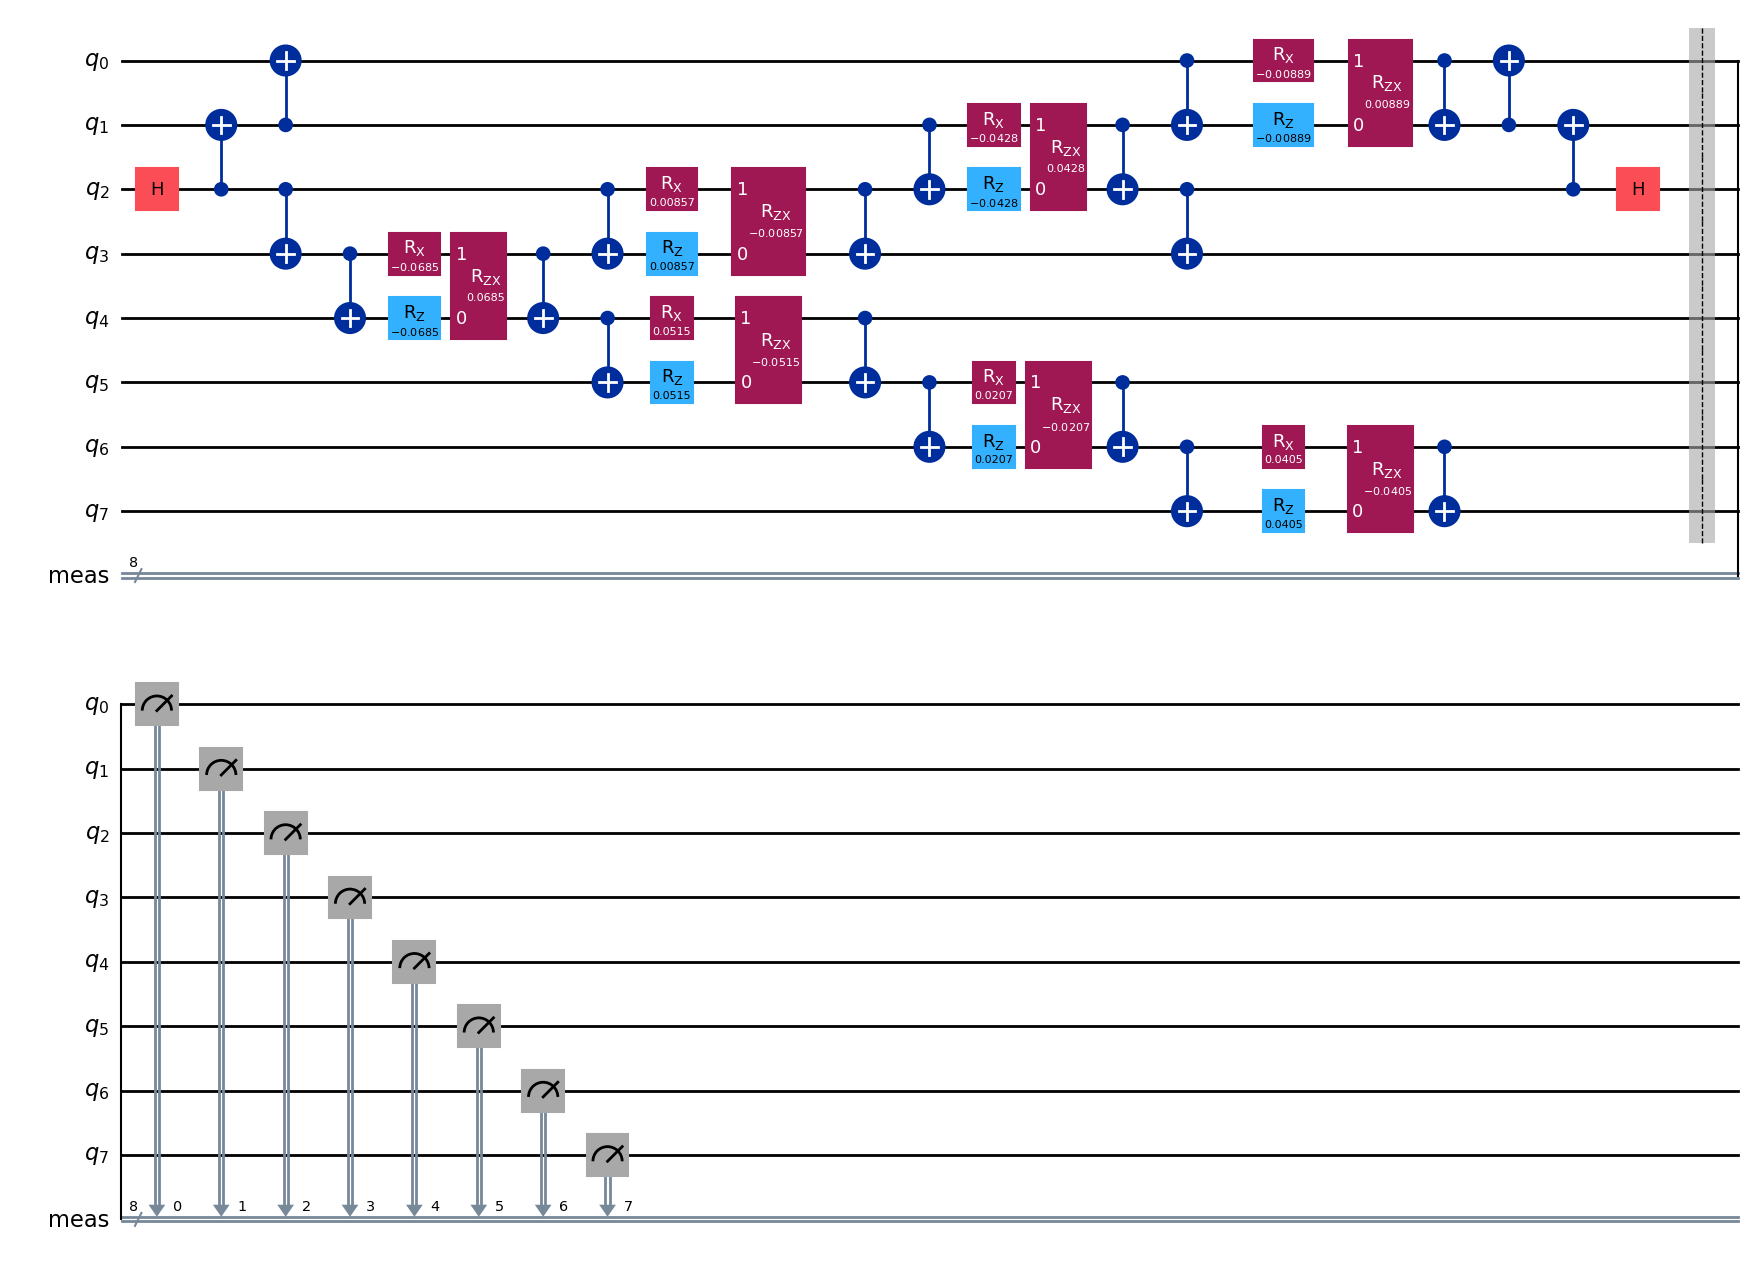

In [28]:
# Check a partial circuit
sample_id = 2
feature_id = 1

print("before transpile")
print(
    f"circuit depth: {circuits_phase0[f'sample{sample_id}'][f'f_{feature_id}'].depth()}"
)
print(
    f"count_ops: {circuits_phase0[f'sample{sample_id}'][f'f_{feature_id}'].count_ops()}"
)
circuits_phase0[f"sample{sample_id}"][f"f_{feature_id}"].draw(
    output="mpl", idle_wires=False
)

In [ ]:
print("before transpile")
print(
    f"circuit depth: {exec_circuits_phase0[f'sample{sample_id}'][f'f_{feature_id}'].depth()}"
)
print(
    f"count_ops: {exec_circuits_phase0[f'sample{sample_id}'][f'f_{feature_id}'].count_ops()}"
)
exec_circuits_phase0[f"sample{sample_id}"][f"f_{feature_id}"].draw(
    output="mpl", idle_wires=False
)

In [ ]:
# Run jobs in batch
job_ids = []
mit = mthree.M3Mitigation(backend_qpu)
with Batch(backend=backend_qpu) as batch:
    sampler = Sampler()
    mit.cals_from_system(runtime_mode=batch)
    # Turn on dynamical decoupling.
    sampler.options.dynamical_decoupling.enable = True

    for i in range(n_samples):
        print(f"Submitting circuits for sample {i}/{n_samples}")
        exec_circuits_per_sample = []
        exec_circuits_per_sample += [
            exec_circuits_phase0[f"sample{i}"][f"f_{k}"] for k in range(n_features)
        ]
        exec_circuits_per_sample += [
            exec_circuits_phase1[f"sample{i}"][f"f_{k}"] for k in range(n_features)
        ]
        exec_circuits_per_sample += [
            exec_circuits_phase2[f"sample{i}"][f"f_{k}"] for k in range(n_features)
        ]
        exec_circuits_per_sample += [
            exec_circuits_phase3[f"sample{i}"][f"f_{k}"] for k in range(n_features)
        ]

        job = sampler.run(exec_circuits_per_sample)
        job_ids.append(job.job_id())

In [ ]:
with open(f"{path}/first_try_job_ids.txt", "w") as f:
    for job_id in job_ids:
        f.write(f"{job_id}\n")

first_try_started_at = batch.details()["started_at"]

In [ ]:
# Note: This line can be finished only after the calibration job (tagged with "M3 calibration") is finished.
mit.cals_to_file(f"{path}/calibrations_{first_try_started_at}.json")

with open(f"{path}/first_try_started_at.txt", "w") as f:
    f.write(first_try_started_at)

## Post process (QPU)

In [ ]:
# Load the params, job IDs and started_at time
# current_time = "2024-11-14T05:27:22.407Z"
with open(f"{path}/params.pkl", "rb") as f:
    params = pickle.load(f)
backend_qpu_name = params["backend_qpu_name"]

In [ ]:
with open(f"{path}/first_try_job_ids.txt", "r") as f:
    first_try_job_ids = [job_id.strip() for job_id in f.readlines()]
with open(f"{path}/first_try_started_at.txt", "r") as f:
    first_try_started_at = f.read()

# Load calibration data
cals_file = f"{path}/calibrations_{first_try_started_at}.json"
mit = mthree.M3Mitigation(backend_qpu)
mit.cals_from_file(cals_file)

In [ ]:
# Scan the status of the jobs
successful_job_ids_and_samples = {}
failed_job_ids_ids_and_samples = {}
successful_results = {}

for i in range(n_samples):
    print(f"Checking job {i}/{n_samples}")
    job_id = first_try_job_ids[i]
    job = service.job(job_id)

    if job.status() == "DONE":
        successful_job_ids_and_samples[f"sample{i}"] = job_id
        successful_results[f"sample{i}"] = job.result()
    elif job.status() == "ERROR":
        failed_job_ids_ids_and_samples[f"sample{i}"] = job_id

print()
print("successful samples and job ids")
for sample_id, job_id in successful_job_ids_and_samples.items():
    print(f"{sample_id}: {job_id}")
print()
print("failed samples and job ids")
for sample_id, job_id in failed_job_ids_ids_and_samples.items():
    print(f"{sample_id}: {job_id}")
print()
print(f"Success rate: { len(successful_job_ids_and_samples) / n_samples }")

with open(f"{path}/successful_job_ids_and_samples.json", "w") as f:
    json.dump(successful_job_ids_and_samples, f)
with open(f"{path}/failed_job_ids_ids_and_samples.json", "w") as f:
    json.dump(failed_job_ids_ids_and_samples, f)

In [ ]:
# Load parameters
with open(f"{path}/params.pkl", "rb") as f:
    params = pickle.load(f)

n_samples = params["n_samples"]
n_qubits = params["n_qubits"]
backend_qpu_name = params["backend_qpu_name"]
beta = params["beta"]
C = params["C"]
n_features = params["n_features"]
times = params["times"]
all_Js = params["Js"]
graphs = params["graphs"]
all_expected_values = params["expected_values"]

In [ ]:
# Note: this is only for the successful jobs

data_qpu_nmit = []
data_qpu_mit = []
probs_phase0_nmit = {}
probs_phase1_nmit = {}
probs_phase2_nmit = {}
probs_phase3_nmit = {}
probs_phase0_mit = {}
probs_phase1_mit = {}
probs_phase2_mit = {}
probs_phase3_mit = {}

# Note: sample_id is string, not integer
for sample_id, result in successful_results.items():
    print(f"Processing job {sample_id}")
    features_nmit = []
    features_mit = []
    probs_phase0_nmit[sample_id] = {}
    probs_phase1_nmit[sample_id] = {}
    probs_phase2_nmit[sample_id] = {}
    probs_phase3_nmit[sample_id] = {}
    probs_phase0_mit[sample_id] = {}
    probs_phase1_mit[sample_id] = {}
    probs_phase2_mit[sample_id] = {}
    probs_phase3_mit[sample_id] = {}

    for k in range(n_features):
        # Get results of each phase in a batch
        # phase_results = result[4 * k : 4 * k + 4]
        # probs = [
        #     get_prob0(phase_result, n_qubits, mit) for phase_result in phase_results
        # ]

        # Get results of each phase in a batch
        results_phase0 = result[:n_features]
        results_phase1 = result[n_features : 2 * n_features]
        results_phase2 = result[2 * n_features : 3 * n_features]
        results_phase3 = result[3 * n_features :]

        prob_phase0_nmit, prob_phase0_mit = get_prob0(results_phase0[k], n_qubits, mit)
        prob_phase1_nmit, prob_phase1_mit = get_prob0(results_phase1[k], n_qubits, mit)
        prob_phase2_nmit, prob_phase2_mit = get_prob0(results_phase2[k], n_qubits, mit)
        prob_phase3_nmit, prob_phase3_mit = get_prob0(results_phase3[k], n_qubits, mit)

        if prob_phase0_mit > 1:
            prob_phase0_mit = 1
        elif prob_phase0_mit < 0:
            prob_phase0_mit = 0
        if prob_phase1_mit > 1:
            prob_phase1_mit = 1
        elif prob_phase1_mit < 0:
            prob_phase1_mit = 0
        if prob_phase2_mit > 1:
            prob_phase2_mit = 1
        elif prob_phase2_mit < 0:
            prob_phase2_mit = 0
        if prob_phase3_mit > 1:
            prob_phase3_mit = 1
        elif prob_phase3_mit < 0:
            prob_phase3_mit = 0

        probs_phase0_nmit[sample_id][f"f_{k}"] = prob_phase0_nmit
        probs_phase1_nmit[sample_id][f"f_{k}"] = prob_phase1_nmit
        probs_phase2_nmit[sample_id][f"f_{k}"] = prob_phase2_nmit
        probs_phase3_nmit[sample_id][f"f_{k}"] = prob_phase3_nmit
        probs_phase0_mit[sample_id][f"f_{k}"] = prob_phase0_mit
        probs_phase1_mit[sample_id][f"f_{k}"] = prob_phase1_mit
        probs_phase2_mit[sample_id][f"f_{k}"] = prob_phase2_mit
        probs_phase3_mit[sample_id][f"f_{k}"] = prob_phase3_mit

        inner_product_nmit = np.exp(-1j * lambda_refs[sample_id] * times[k]) * (
            (prob_phase0_nmit - prob_phase1_nmit)
            + 1j * (prob_phase2_nmit - prob_phase3_nmit)
        )
        inner_product_mit = np.exp(-1j * lambda_refs[sample_id] * times[k]) * (
            (prob_phase0_mit - prob_phase1_mit)
            + 1j * (prob_phase2_mit - prob_phase3_mit)
        )
        features_nmit.append(inner_product_nmit.real)
        features_mit.append(inner_product_mit.real)
        if k != 0:
            features_nmit.append(inner_product_nmit.imag)
            features_mit.append(inner_product_mit.imag)

    # Because sample_id is string (e.g. "sample0"), convert it to integer.
    sample_id_int = int(sample_id.replace("sample", ""))
    data_qpu_nmit.append(
        [sample_id_int, *features_nmit, all_expected_values[sample_id_int]]
    )
    data_qpu_mit.append(
        [sample_id_int, *features_mit, all_expected_values[sample_id_int]]
    )

# Create column names for the DataFrame
columns = []
columns.append("sample_id")
for k in range(n_features):
    columns.append(f"f_{k} Re")
    if k != 0:
        columns.append(f"f_{k} Im")
columns.append("expected_value")

# Convert to a DataFrame
data_qpu_nmit_df = pd.DataFrame(data_qpu_mit, columns=columns)
data_qpu_mit_df = pd.DataFrame(data_qpu_nmit, columns=columns)
print("QPU no mitigation")
display(data_qpu_nmit_df)
print("QPU with mitigation")
display(data_qpu_mit_df)

# Save the qpu data
data_qpu_nmit_df.to_json(f"{path}/data_qpu_nmit_df.json")
data_qpu_mit_df.to_json(f"{path}/data_qpu_mit_df.json")

## Plot data

In [27]:
dummy_successful_results = {}
for i in range(n_samples):
    dummy_successful_results[f"sample{i}"] = None

successful_results = dummy_successful_results

In [28]:
probs_phase0_exact_extracted = extract_probs(
    probs_phase0_exact, successful_results.keys()
)
probs_phase1_exact_extracted = extract_probs(
    probs_phase1_exact, successful_results.keys()
)
probs_phase2_exact_extracted = extract_probs(
    probs_phase2_exact, successful_results.keys()
)
probs_phase3_exact_extracted = extract_probs(
    probs_phase3_exact, successful_results.keys()
)

probs_phase0_sim_extracted = extract_probs(probs_phase0_sim, successful_results.keys())
probs_phase1_sim_extracted = extract_probs(probs_phase1_sim, successful_results.keys())
probs_phase2_sim_extracted = extract_probs(probs_phase2_sim, successful_results.keys())
probs_phase3_sim_extracted = extract_probs(probs_phase3_sim, successful_results.keys())

probs_phase0_sim_noisy_extracted = extract_probs(
    probs_phase0_sim_noisy, successful_results.keys()
)
probs_phase1_sim_noisy_extracted = extract_probs(
    probs_phase1_sim_noisy, successful_results.keys()
)
probs_phase2_sim_noisy_extracted = extract_probs(
    probs_phase2_sim_noisy, successful_results.keys()
)
probs_phase3_sim_noisy_extracted = extract_probs(
    probs_phase3_sim_noisy, successful_results.keys()
)

# probs_phase0_nmit_extracted = extract_probs(
#     probs_phase0_nmit, successful_results.keys()
# )
# probs_phase1_nmit_extracted = extract_probs(
#     probs_phase1_nmit, successful_results.keys()
# )
# probs_phase2_nmit_extracted = extract_probs(
#     probs_phase2_nmit, successful_results.keys()
# )
# probs_phase3_nmit_extracted = extract_probs(
#     probs_phase3_nmit, successful_results.keys()
# )

# probs_phase0_mit_extracted = extract_probs(probs_phase0_mit, successful_results.keys())
# probs_phase1_mit_extracted = extract_probs(probs_phase1_mit, successful_results.keys())
# probs_phase2_mit_extracted = extract_probs(probs_phase2_mit, successful_results.keys())
# probs_phase3_mit_extracted = extract_probs(probs_phase3_mit, successful_results.keys())

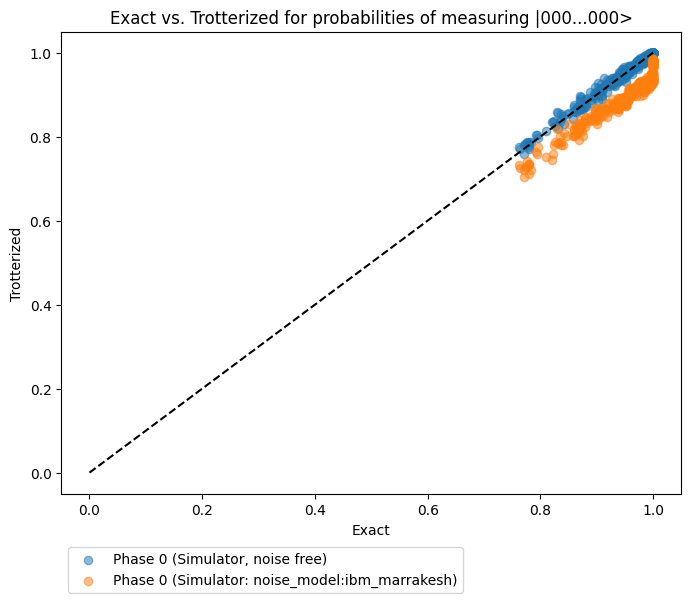

In [29]:
# Plot exact vs. Trotterized results
plt.figure(figsize=(8, 6))
plt.scatter(
    probs_phase0_exact_extracted,
    probs_phase0_sim_extracted,
    label=f"Phase 0 (Simulator, noise free)",
    alpha=0.5,
)
plt.scatter(
    probs_phase0_exact_extracted,
    probs_phase0_sim_noisy_extracted,
    label=f"Phase 0 (Simulator: noise_model:{backend_qpu.name})",
    alpha=0.5,
)
# plt.scatter(
#     probs_phase0_exact_extracted,
#     probs_phase0_nmit_extracted,
#     label=f"Phase 0 (QPU: {backend_qpu.name}, no mitigation)",
#     alpha=0.5,
# )
# plt.scatter(
#     probs_phase0_exact_extracted,
#     probs_phase0_mit_extracted,
#     label=f"Phase 0 (QPU: {backend_qpu.name}, with mitigation)",
#     alpha=0.5,
# )
# Plot the 1:1 line
plt.plot([0, 1], [0, 1], "--", color="black")
plt.xlabel("Exact")
plt.ylabel("Trotterized")
plt.legend(bbox_to_anchor=(0, -0.1), loc="upper left")
plt.title("Exact vs. Trotterized for probabilities of measuring |000...000>")
plt.show()

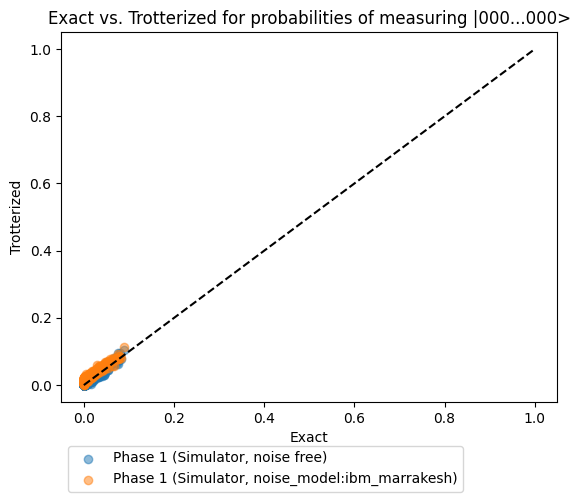

In [30]:
plt.scatter(
    probs_phase1_exact_extracted,
    probs_phase1_sim_extracted,
    label=f"Phase 1 (Simulator, noise free)",
    alpha=0.5,
)
plt.scatter(
    probs_phase1_exact_extracted,
    probs_phase1_sim_noisy_extracted,
    label=f"Phase 1 (Simulator, noise_model:{backend_qpu.name})",
    alpha=0.5,
)
# plt.scatter(
#     probs_phase1_exact_extracted,
#     probs_phase1_nmit_extracted,
#     label=f"Phase 1 (QPU: {backend_qpu.name}, no mitigation)",
#     alpha=0.5,
# )
# plt.scatter(
#     probs_phase1_exact_extracted,
#     probs_phase1_mit_extracted,
#     label=f"Phase 1 (QPU: {backend_qpu.name}, with mitigation)",
#     alpha=0.5,
# )
# Plot the 1:1 line
plt.plot([0, 1], [0, 1], "--", color="black")
plt.xlabel("Exact")
plt.ylabel("Trotterized")
plt.legend(bbox_to_anchor=(0, -0.1), loc="upper left")
plt.title("Exact vs. Trotterized for probabilities of measuring |000...000>")
plt.show()

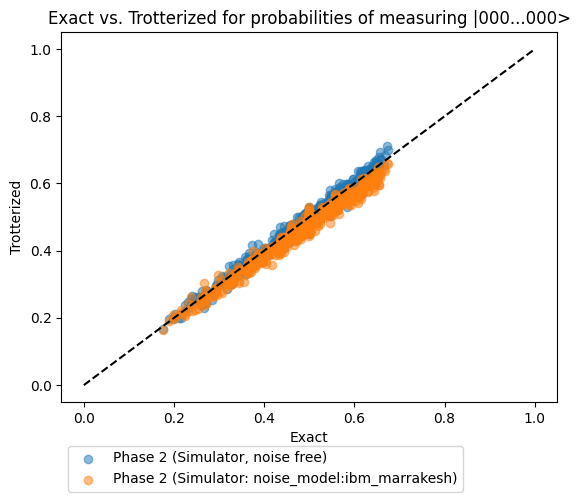

In [31]:
plt.scatter(
    probs_phase2_exact_extracted,
    probs_phase2_sim_extracted,
    label=f"Phase 2 (Simulator, noise free)",
    alpha=0.5,
)
plt.scatter(
    probs_phase2_exact_extracted,
    probs_phase2_sim_noisy_extracted,
    label=f"Phase 2 (Simulator: noise_model:{backend_qpu.name})",
    alpha=0.5,
)
# plt.scatter(
#     probs_phase2_exact_extracted,
#     probs_phase2_nmit_extracted,
#     label=f"Phase 2 (QPU: {backend_qpu.name}, no mitigation)",
#     alpha=0.5,
# )
# plt.scatter(
#     probs_phase2_exact_extracted,
#     probs_phase2_mit_extracted,
#     label=f"Phase 2 (QPU: {backend_qpu.name}, with mitigation)",
#     alpha=0.5,
# )
# Plot the 1:1 line
plt.plot([0, 1], [0, 1], "--", color="black")
plt.xlabel("Exact")

plt.ylabel("Trotterized")
plt.legend(bbox_to_anchor=(0, -0.1), loc="upper left")
plt.title("Exact vs. Trotterized for probabilities of measuring |000...000>")
plt.show()

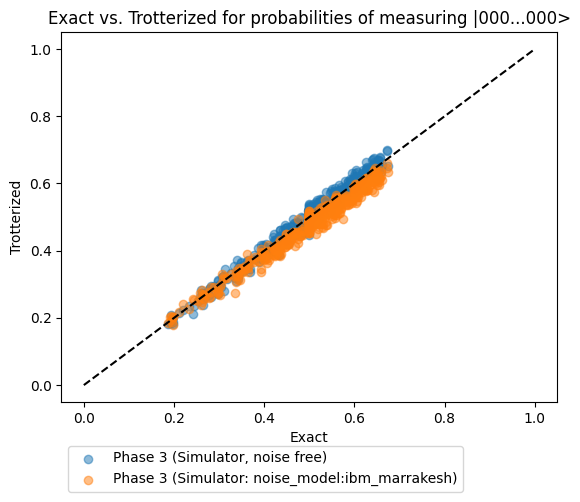

In [32]:
plt.scatter(
    probs_phase3_exact_extracted,
    probs_phase3_sim_extracted,
    label=f"Phase 3 (Simulator, noise free)",
    alpha=0.5,
)
plt.scatter(
    probs_phase3_exact_extracted,
    probs_phase3_sim_noisy_extracted,
    label=f"Phase 3 (Simulator: noise_model:{backend_qpu.name})",
    alpha=0.5,
)
# plt.scatter(
#     probs_phase3_exact_extracted,
#     probs_phase3_nmit_extracted,
#     label=f"Phase 3 (QPU: {backend_qpu.name}, no mitigation)",
#     alpha=0.5,
# )
# plt.scatter(
#     probs_phase3_exact_extracted,
#     probs_phase3_mit_extracted,
#     label=f"Phase 3 (QPU: {backend_qpu.name}, with mitigation)",
#     alpha=0.5,
# )
# Plot the 1:1 line
plt.plot([0, 1], [0, 1], "--", color="black")
plt.xlabel("Exact")
plt.ylabel("Trotterized")
plt.legend(bbox_to_anchor=(0, -0.1), loc="upper left")
plt.title("Exact vs. Trotterized for probabilities of measuring |000...000>")
plt.show()